# Input Driven Observations ("GLM-HMM")

Notebook adapted from Zoe Ashwood

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sglm import hmmUtils, utils
import ssm

npr.seed(42)

#### 1a. Below, we will be importing the data and filtering based on any feature you would like.

In [2]:
data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')

C:\Users\janet\AppData\Local\Temp\ipykernel_31972\1526347576.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')


##### 1a.1. Define training and testing data

In [3]:
probs = '80-20'
train_split = 0.7
seed = np.random.randint(1000)

filtered_data = data_[(data_['Condition'] == probs)]

In [ ]:
#filtered_data.loc[:, 'Decision'] = filtered_data['Decision'].replace(0, -1)

In [4]:
## Get train/test session IDs

train_ids, test_ids = train_test_split(filtered_data['Session ID'].unique(), 
                                       train_size=train_split, random_state=seed)

print('You have {} training sessions and {} test sessions.'.format(len(train_ids), len(test_ids)))

You have 410 training sessions and 177 test sessions.


In [5]:
unique_elements = np.array([s.split('_')[0] for s in test_ids])

# Count and list unique elements
unique_test_elements_count = np.unique(unique_elements).size
unique_test_elements_list = np.unique(unique_elements)

# Print the results
print(f"Number of unique test elements: {unique_test_elements_count}")
print(f"List of unique test elements: {unique_test_elements_list}")

Number of unique test elements: 61
List of unique test elements: ['AB' 'AN' 'AR' 'BB' 'BL' 'BN' 'BR' 'CB' 'CL' 'CN' 'CR' 'DB' 'DL' 'DLL'
 'DN' 'EB' 'EL' 'EN' 'ER' 'FB' 'FL' 'FN' 'FR' 'GB' 'GL' 'GN' 'GR' 'HL'
 'HN' 'IL' 'IL2' 'IN' 'IR' 'JB' 'JL' 'JN' 'JR' 'KJM1' 'KJM10' 'KJM11'
 'KJM2' 'KJM3' 'KJM4' 'KJM5' 'KJM6' 'KJM62' 'KJM63' 'KJM7' 'KJM8' 'KJM9'
 'MB' 'MN' 'MR' 'OB' 'OL' 'ON' 'YB' 'YL' 'YN' 'YR' 'cn']


In [ ]:
unique_r_elements = np.array([s.split('_')[0] for s in train_ids])

# Count and list unique elements
unique_train_elements_count = np.unique(unique_r_elements).size
unique_train_elements_list = np.unique(unique_r_elements)

# Print the results
print(f"Number of unique train elements: {unique_train_elements_count}")
print(f"List of unique train elements: {unique_train_elements_list}")

In [ ]:
# no of overlapping elements
overlap = np.intersect1d(unique_r_elements, unique_elements)
print(f"Number of overlapping elements: {overlap.size}")

In [6]:
## Create new dataframes for train/test data

train_data = filtered_data[filtered_data['Session ID'].isin(train_ids)]
test_data = filtered_data[filtered_data['Session ID'].isin(test_ids)]

In [ ]:
pd.set_option('display.max_columns', None)
train_data

In [7]:
# Extracting specific columns and creating variables for model input
x_cols = ['1_Port', '2_Port', '1_Reward', '2_Reward', '3_Port', '3_Reward']
y_cols = ['Reward']

#columns for x and y data
train_data_x = train_data[x_cols]
train_data_y = train_data[y_cols]
test_data_x = test_data[x_cols]
test_data_y = test_data[y_cols]

#number of sessions and trials
train_data_sessions = len(train_data_x)
test_data_sessions = len(test_data_x)

train_num_sess = len(train_data['Session ID'].unique())
test_num_sess = len(test_data['Session ID'].unique())

num_trials_per_train_sess = train_data_sessions
num_trials_per_test_sess = test_data_sessions

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

Input-Driven Observations: This means that the observations you see (e.g., the weather you observe) are influenced by some external factors or covariates. For example, the probability of observing rain on a particular day might be influenced by the temperature or humidity on that day.

Input-Driven Transitions: This means that the transition probabilities between different hidden states (e.g., different weather patterns) are influenced by external factors. For example, the likelihood of transitioning from a sunny day to a rainy day might depend on some external factors.

Stationary Transitions: On the other hand, "stationary transitions" mean that the transitions between hidden states are fixed and do not depend on external inputs. In the context of the weather, this would mean that the probability of transitioning from one weather pattern to another is constant and doesn't change based on external factors.

## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [8]:
# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()

# Model Inputs
num_states = 2 # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [10]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="inputdriven") # transitions usually standard


In [11]:
N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(choices, inputs=inpts, method='em', num_iters=N_iters, tolerance=10**-4) #method="em",
print("EM converged: ", fit_ll)

  0%|          | 0/500 [00:00<?, ?it/s]

EM converged:  [-94288.19600394693, -94288.19600327742, -93675.06526490091, -91453.94582218061, -87487.1047967381, -83544.99188834324, -80344.71135733508, -78126.39347309785, -76775.05560379225, -75999.47535709597, -75522.1820683202, -75235.29449740374, -75009.68234854387, -74691.12654114503, -74530.32819991585, -74408.74973403885, -74287.21033686714, -74241.94543926891, -74157.72812993471, -74059.88520901724, -74020.70170271891, -73994.90383200631, -73954.4666398727, -73928.53119914029, -73807.30099168776, -73773.99246161779, -73738.33756807254, -73704.20140317324, -73669.69610903904, -73629.17915565384, -73594.58015232366, -73478.0669900699, -73431.41983754792, -73400.45872391581, -73353.97559132508, -73328.58315765635, -73229.55481941142, -73185.18551429297, -73165.75610564621, -73147.65949693212, -73137.29917770377, -73122.337868315, -73111.32540775834, -73098.0501847329, -73085.89280983745, -73073.6030602715, -73059.35066698799, -73047.45009569215, -73029.00223234513, -73016.86493

In [17]:
#fit to test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()

test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts)
print("Test LL: ", test_ll)

Test LL:  -32666.036664892672


In [13]:
#normalize the log likelihood
norm_ll = [s / num_trials_per_train_sess for s in fit_ll if s is not None]
norm_test = test_ll / num_trials_per_test_sess

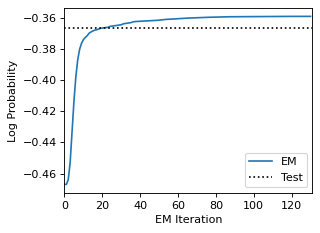

In [14]:
# Plot the log probabilities of the train and test models. Fit model final LL should be greater 
# than or equal to true LL.

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(norm_ll, label="EM")
plt.plot([0, len(norm_ll)], norm_test * np.ones(2), ':k', label="Test")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [15]:
T = inpts.shape[0] # number of trials
K = 2 # number of latent states
C = 2 # number of observation classes or # C represents the binary choice the animal must make
D = inpts.shape[1] # number of GLM inputs (regressors)

# # Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]

Text(0, 0.5, 'p(state)')

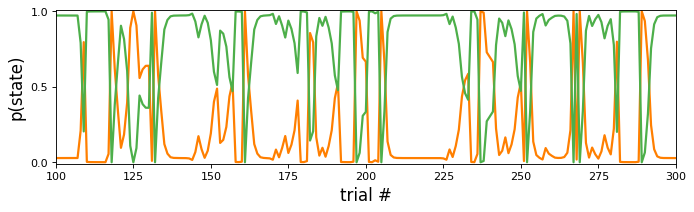

In [18]:
trials_to_plot = (100, 300) # number of trials to plot

cols = ['#ff7f00', '#4daf4a', '#377eb8']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [19]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

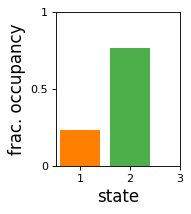

In [20]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

(0.0, 6.0)

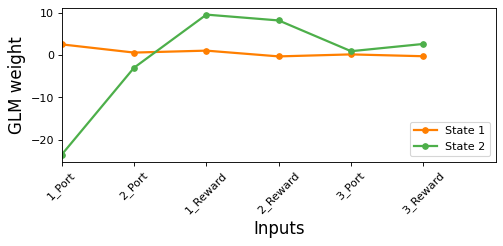

In [21]:
model_gen_weights = new_glmhmm.observations.params

#Plot the weights for each input regressor against each state
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(model_gen_weights[k,0,:], label="State " + str(k + 1), lw=2,
             color=cols[k], marker = 'o', markersize = 5)
plt.legend(loc="lower right")
plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
plt.ylabel("GLM weight", fontsize = 15)
plt.xlabel("Inputs", fontsize = 15)
plt.xlim((0, len(x_cols)))


In [ ]:
filtered_data.loc[:, 'State_Occupancy'] = state_max_posterior # State_Max_Posterior contains the state for each given trial 

#save new csv
#filtered_data.to_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FullMerged_2nBack_100423.csv', index=True)

## Picking the optimal number of states - Let's loop through a list of num_states and see which one produces the highest log likelihood.

We will be looping through a list of num_states and running the model on each. We will then plot the log likelihoods and see which number of states produces the highest log likelihood. Importantly, we are changing our observation to 'bernoulli', which assumes that the observations are binary. This is because we are modeling the animal's choice data, which is binary.

In [ ]:
probs = '80-20'
train_split = 0.8
seed = np.random.randint(1000)

filtered_data = data_[(data_['Condition'] == probs)]

## Get train/test session IDs

train_ids, test_ids = train_test_split(filtered_data['Session ID'].unique(), 
                                       train_size=train_split, random_state=seed)

print('You have {} training sessions and {} test sessions.'.format(len(train_ids), len(test_ids)))

In [ ]:
## Create new dataframes for train/test data

train_data = filtered_data[filtered_data['Session ID'].isin(train_ids)]
test_data = filtered_data[filtered_data['Session ID'].isin(test_ids)]

In [ ]:
# Extracting specific columns and creating variables for model input
x_cols = ['1_Port', '2_Port', '1_Reward', '2_Reward', '3_Port', '3_Reward']
y_cols = ['Reward']

#columns for x and y data
train_data_x = train_data[x_cols]
train_data_y = train_data[y_cols]
test_data_x = test_data[x_cols]
test_data_y = test_data[y_cols]

#number of sessions and trials
train_data_sessions = len(train_data_x)
test_data_sessions = len(test_data_x)

train_num_sess = len(train_data['Session ID'].unique())
test_num_sess = len(test_data['Session ID'].unique())

num_trials_per_train_sess = train_data_sessions
num_trials_per_test_sess = test_data_sessions

In [ ]:
# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()


# Model Inputs
num_states = [1, 2, 3, 4] # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [ ]:
test_glmhmm_list = []
fit_ll_list = []
for i in range(len(num_states)):
    
    test_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="bernoulli")

    N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
    fit_ll = test_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)
    test_glmhmm_list.append(test_glmhmm)
    fit_ll_list.append(fit_ll)


In [ ]:
for ii in range(len(test_glmhmm_list)):
    log_likelihood = test_glmhmm_list[ii].log_likelihood(choices, inputs=inpts)
    print('Model with ' + str(num_states[ii]) + ' states has a train log likelihood of ' + str(log_likelihood))

In [ ]:
#determine LL of held out test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()
test_ll_list = []

for ii in range(len(test_glmhmm_list)):
    test_ll_list.append(test_glmhmm_list[ii].log_likelihood(test_choices, inputs=test_inpts))
    print('Model with ' + str(num_states[ii]) + ' states has a test log likelihood of ' + str(test_ll_list[ii]))
    

In [ ]:
#normalize log likelihood in test_glmhmm_list and test_ll_list
norm_ll_list = []
norm_test_ll_list = []
for ii in range(len(fit_ll_list)):
    norm_ll_list.append([k / num_trials_per_train_sess for k in fit_ll_list[ii] if k is not None])
    norm_test_ll_list.append(test_ll_list[ii] / num_trials_per_test_sess)

In [ ]:
# Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
axs = axs.ravel()
for ii in range(len(fit_ll_list)):
    axs[ii].plot(norm_ll_list[ii], label="EM")
    axs[ii].plot([0, len(norm_ll_list[ii])], norm_test_ll_list[ii] * np.ones(2), ':k', label="Test")
    axs[ii].legend(loc="lower right")
    axs[ii].set_xlabel("EM Iteration")
    axs[ii].set_xlim(0, len(norm_ll_list[ii]))
    axs[ii].set_ylabel("Log Probability")
    axs[ii].set_title('Model with ' + str(num_states[ii]) + ' states')

In [ ]:
#Convert to bits per state for train data
bits_per_state_train = []
for ii in range(len(test_glmhmm_list)):
    import math
    bits_per_sess = ((test_glmhmm_list[ii].log_likelihood(choices, inputs=inpts)-(np.log(0.5)*num_trials_per_train_sess))/(num_trials_per_train_sess*np.log(2)))
    bits_per_state_train.append(bits_per_sess)

In [ ]:
#Convert to bits per state for test data
bits_per_state_test = []
for ii in range(len(test_glmhmm_list)):
    import math
    bits_per_sess = ((test_glmhmm_list[ii].log_likelihood(test_choices, inputs=test_inpts)-(np.log(0.5)*num_trials_per_test_sess))/(num_trials_per_test_sess*np.log(2)))
    bits_per_state_test.append(bits_per_sess)

In [ ]:
#Plot bits/state train vs test
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, bits_per_state_train, label="Train", marker='o')
plt.plot(num_states, bits_per_state_test, label="Test", marker='o')
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("bits/trials")
plt.xticks(num_states)
plt.show()

In [ ]:
#Calculate AIC  for train data normalized by number of trials
AIC_train = []
for ii in range(len(test_glmhmm_list)):
    AIC = (-2*(test_glmhmm_list[ii].log_likelihood(choices, inputs=inpts)/num_trials_per_train_sess))+(2*(num_states[ii]))
    AIC_train.append(AIC)

In [ ]:
##Calculate AIC for test data normalized by number of trials
AIC_test = []
for ii in range(len(test_glmhmm_list)):
    AIC = (-2*(test_glmhmm_list[ii].log_likelihood(test_choices, inputs=test_inpts)/num_trials_per_test_sess))+(2*(num_states[ii]))
    AIC_test.append(AIC)

In [ ]:
#Plot AIC for train and test data side by side
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.4)

plt.plot(num_states, AIC_train, label="AIC Train", marker='o', color='green')
plt.plot(num_states, AIC_test, label="AIC Test", marker='o', color='magenta')
plt.legend(loc="upper left")
plt.xlabel("Number of States")
plt.ylabel("AIC")
plt.xticks(num_states)



### Plotting transition matrix: Here, we will look at the resulting transition matrix. You can select any model output from the list below to plot.

In [ ]:
num_states_2plot = 2
gen_weights = test_glmhmm_list[1].observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = test_glmhmm_list[1].transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states_2plot), ('1', '2'), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

### Now, we will be calculating the prediction accuracy of the model. We will be using the input driven observation model to predict the animal's choice on each trial, and then comparing that to the actual choice. We will then plot the prediction accuracy for each state. Importantly, we are changing our observation to 'input driven' and the transitions to 'sticky'. 

In [ ]:
##This needs to be done using the input driven observations class from Zoe Ashwood's code and Scott's code

# C represents the binary choice the animal must make 
C = 2 

# number of discrete states
num_states = 3 
prior_sigma = 2
prior_alpha = 2

# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()

# Model Inputs
num_states = [1, 2, 3, 4] # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]


In [ ]:
sticky_model_list = []
for i in range(len(num_states)):
    map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    sticky_model_list.append(map_glmhmm)

In [ ]:
# # Get expected states for each model:
expectations_list = []
for i in range(len(num_states)):
    expectations_list.append([sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])])

In [ ]:
#calculate predictive accuracy for each model
predictive_acc_list = []
for i in range(len(num_states)):
    model = sticky_model_list[i]
    expectations = expectations_list[i]
    permutation = hmmUtils.calculate_state_permutation(model.params)
    train_masks = [np.ones_like(data, dtype=bool) for data in [choices]]
    # Convert this now to one array:
    posterior_probs = np.concatenate(expectations, axis=0)
    posterior_probs = posterior_probs[:, permutation]
    prob_right = [
        np.exp(model.observations.calculate_logits(input=inpts))
        for data, input, train_mask in zip(choices, inpts, train_masks)
    ]
    prob_right = np.concatenate(prob_right, axis=0)
    # Now multiply posterior probs and prob_right:
    prob_right = prob_right[:, :, 1]
    # Now multiply posterior probs and prob_right and sum over latent axis:
    final_prob_right = np.sum(np.multiply(posterior_probs, prob_right), axis=1)
    # Get the predicted label for each time step:
    predicted_label = np.around(final_prob_right, decimals=0).astype('int')
    # Examine at appropriate idx
    predictive_acc = np.sum(choices[:, 0] == predicted_label) / len(choices)
    predictive_acc_list.append(predictive_acc)


In [ ]:
#plot predictive accuracy for each model
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, predictive_acc_list, label="Predictive Accuracy", marker='o')
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("Predictive Accuracy")
plt.xticks(num_states)
plt.show()